## Tools to read from the PixelFly PCO cam

This is mostly modified from https://github.com/patapisp/PCO_PixelFly/blob/master/core/pco_definitions.py

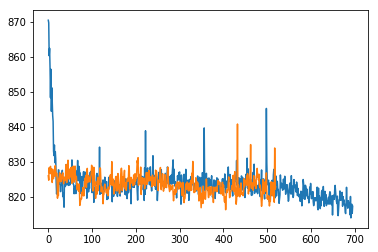

In [27]:
import pylab as plt
%matplotlib inline
#plt.imshow(cam.img)
plt.plot(cam.img.mean(axis = 0))
plt.plot(cam.img.mean(axis = 1))
plt.show()


In [1]:
from labcams.pixelfly import *
cam = PCOCam(0)

cam.daemon = False
cam.start()
cam.startTrigger.set()

[19-01-31 13:47:04] - PCO - Binning: [2, 2]
[19-01-31 13:47:04] - PCO - Exposure: 100 ms
[19-01-31 13:47:04] - PCO - Trigger mode: 0
PCO - size: None x None
[19-01-31 13:47:07] - Got info from camera (name: PixelFly)


In [28]:
cam.stopTrigger.set()
cam.closeEvent.set()

In [9]:
cam.startTrigger.set()

In [2]:
import pco
exposure = 15 # ms
binning = 4

cam = pco.camera(debuglevel = 'verbose')

[][sdk] open_camera: OK.
[][sdk] get_recording_state: OK.
[][sdk] reset_settings_to_default: OK.
[][sdk] set_bit_alignment: OK.
[][sdk] arm_camera: OK.


In [42]:
cam.sdk.set_binning('{0}x{0}'.format(binning))
cam.set_exposure_time(exposure_time= exposure*1.e-3)


[][sdk] set_binning: OK.
[][sdk] set_delay_exposure_time: OK.


In [3]:
cam.sdk.get_binning()
cam.close()

[][sdk] get_binning: OK.
[][sdk] close_camera: OK.


[][rec] stop_record: OK.
[][rec] delete: OK.
[][sdk] close_camera: SDK DLL error a00a3002 at device 'camera sdk dll': Handle is invalid.


NameError: name 'exception' is not defined

In [1]:
from pco.sdk import sdk
dll = sdk()
# cam = dll.open_camera()

In [4]:
sdk.get_sizes??

In [30]:
import pco
from pco.recorder import recorder
import cv2
# cam = pco.camera(debuglevel = 'verbose')
# cam.record(10,'ring buffer')

dll.set_image_parameters??

In [6]:
while True:
    img,meta = cam.image(0xFFFFFFFF)
    cv2.imshow('etst',img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [12]:
cam.sdk.set_binning('{0}x{0}'.format(4))
cam.sdk.get_sizes()

[][sdk] set_binning: OK.
[][sdk] get_sizes: OK.


{'wXResAct': 2560, 'wXResMax': 2560, 'wYResAct': 2160, 'wYResMax': 2160}

In [ ]:
sdk.
sdk.set_binning('{0}x{0}'.format(4))
sdk.get_sizes()


In [21]:
cam.sdk.set_binning('4x4')

[][sdk] set_binning: SDK DLL error a00a3002 at device 'camera sdk dll': Handle is invalid.


exception: Exception: set_binning a00a3002